# Train classifier

In [1]:
import pickle
import glob

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Helpers functions

In [2]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    img: (M, N, H) ndarray
    bboxes: bounding box positions, [((x1, y1), (x2, y2)), ((,),(,)), ...]
    color: optional 3-tuple, for example, (0, 0, 255) for blue
    thick: optional integer parameter to define the box thickness
    '''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    '''
    img: (M, N, H) ndarray
    
    nbins: optional, bins is an int, it defines the number of equal-width bins in the given range
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    '''
    img: (M, N, H) ndarray
    
    size: optional 2-tuple, output image size
    '''
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()

    # Return the feature vector
    return np.hstack((color1, color2, color3))


# Define a function to return HOG (Histogram of Oriented Gradient) features and visualization
def get_hog_features(img, orient=9, pix_per_cell=(8,8), cell_per_block=(8,8), 
                        vis=False, feature_vec=True):
    '''
    img: (M, N) ndarray,  single color channel or grayscaled image
    
    orient: optional, integer, and represents the number of orientation bins that the gradient information
            will be split up into in the histogram. Typical values are between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, cell size over which each gradient histogram is computed. This paramater
                  is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are
                  commonly chosen to be square
                   
    cell_per_block: optional 2-tuple, and specifies the local area over which the histogram counts in a given
                    cell will be normalized. Block normalization is not necessarily required, but generally
                    leads to a more robust feature set
                    
    vis: flag tells the function to output a visualization of the HOG feature computation or not
    
    feature_vec: flag tells the function to unroll the feature array into a feature vector using same as
                 features.ravel() would do, which yields, in this case, to a one dimensional array
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=pix_per_cell,
                                  cells_per_block=cell_per_block, 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:         
        features = hog(img, orientations=orient, 
                   pixels_per_cell=pix_per_cell,
                   cells_per_block=cell_per_block, 
                   transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
            
        return features

    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', hist_bins=32,
                     spatial_size=(32, 32),
                     orient=9, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0,
                     hist_feat=True, spatial_feat=True, hog_feat=True):
    '''
    imgs:  list of image filenames
    
    color_space: optional for color feature extraction,'RGB', 'HSV', 'LUV', 'HLS', 'YUV' or 'YCrCb' 
    
    hist_bins: optional for color feature extraction, bins is an int, it defines the number of
               equal-width bins in the given range
               
    spatial_size: optional for spatial bining, 2-tuple, spatial binning output image size
    
    orient: optional for HOG feature extraction, integer, and represents the number of orientation bins
            that the gradient information will be split up into in the histogram. Typical values are
            between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, for HOG feature extraction, cell size over which each gradient histogram is computed.
                  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y,
                  but cells are commonly chosen to be square
                  
    cell_per_block: optional 2-tuple, for HOG feature extraction, specifies the local area over which the
                    histogram counts in a given cell will be normalized. Block normalization is not 
                    necessarily required, but generally leads to a more robust feature set
                    
    hog_channel: optional for HOG feature extraction, which channel t apply HOG: 0, 1, 2 or "ALL"
    
    hist_feat: flag to apply or not color histogram feature extraction
    
    spatial_feat: flag to apply or not spatial binning
    
    hog_feat: flag to apply or not HOG feature extraction
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #print('len spatial_features in extract_features',len(spatial_features))
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #print('len hist_features in extract_features',len(hist_features))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print('len hog_features in extract_features',len(hog_features))
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### Load training data

In [3]:
cars = glob.glob('training_dataset/vehicles/**/*.png')
notcars = glob.glob('training_dataset/non-vehicles/**/*.png')

### Explore the training data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


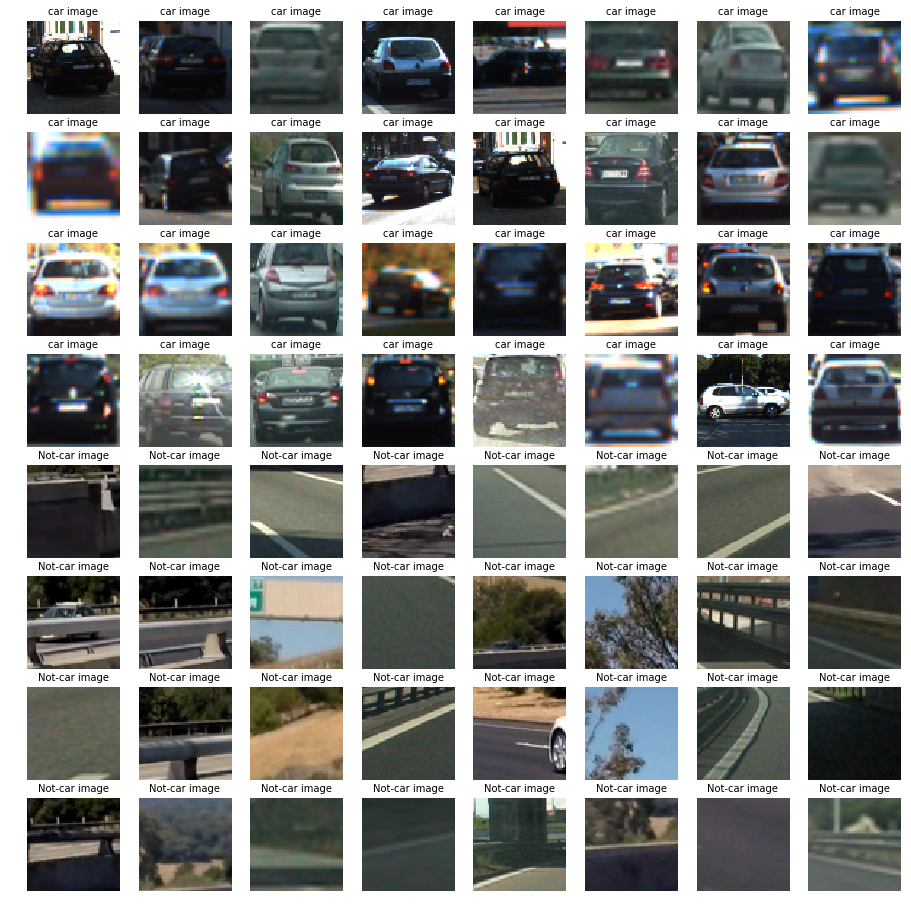

In [4]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    '''
    car_list: list of image filenames
    notcar_list: list of image filenames
    '''
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


# Visualize it
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car image', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not-car image', fontsize=10)
    axs[i].imshow(img)

### Training the classifier

In [5]:
# Parameter tunning
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = (8,8) # HOG pixels per cell
cell_per_block = (2,2) # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        hist_bins=hist_bins, spatial_size=spatial_size, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        hist_bins=hist_bins, spatial_size=spatial_size, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat)



/media/ricardo/MyFiles/anaconda3/envs/carnd-t1-36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations (8, 8) pixels per cell and (2, 2) cells per block
Feature vector length: 4932
21.05 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [7]:
# HOG Features during training
# which must be same size later for predictions
window_pixel_x = 64 # size of image used for training
window_pixel_y = 64 # size of image used for training
n_cell_per_window_x = int(window_pixel_x/pix_per_cell[0])
n_cell_per_window_y = int(window_pixel_y/pix_per_cell[1])
n_blocks_position_per_window_x = n_cell_per_window_x - (cell_per_block[0]-1)
n_blocks_position_per_window_y = n_cell_per_window_y - (cell_per_block[1]-1)


features_1_channel = n_blocks_position_per_window_x * n_blocks_position_per_window_y * cell_per_block[0] \
                        * cell_per_block[1] * orient

print('Features 1 channel',features_1_channel)
print('n block position per window x',n_blocks_position_per_window_x)
print('n block position per window y',n_blocks_position_per_window_y)
print('n cells per block x',cell_per_block[0])
print('n cells per block y',cell_per_block[1])
print('n orientations per cell',orient)
print()
print('n cells per window x',n_cell_per_window_x)
print('n cells per window y',n_cell_per_window_y)
print('pixel per cell x', pix_per_cell[0])
print('pixel per cell y', pix_per_cell[1])
print('window pixels x', window_pixel_x)
print('window pixels y', window_pixel_y)

Features 1 channel 1764
n block position per window x 7
n block position per window y 7
n cells per block x 2
n cells per block y 2
n orientations per cell 9

n cells per window x 8
n cells per window y 8
pixel per cell x 8
pixel per cell y 8
window pixels x 64
window pixels y 64


### Checkpoint - Save Training Data

In [8]:
# Save the trained classifier for later use
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

dist_pickle["color_space"] = color_space
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
dist_pickle["y_start_stop"] = y_start_stop

pickle.dump( dist_pickle, open( "training_dataset/trained_dist_pickle.p", "wb" ) )
